## Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import json

## Directory paths and image settings

In [2]:
DATADIR = r"E:\data_final\train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED=40

## Data Augmentation & Preprocessing

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=3,         
    width_shift_range=0.01,       
    height_shift_range=0.01,     
    shear_range=0.01,           
    zoom_range=0.01,              
    horizontal_flip=True,        
    fill_mode='nearest'          
)

## Training Data Generator

In [4]:
train_generator = datagen.flow_from_directory(
    DATADIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 13800 images belonging to 46 classes.


## Validation Data Generator

In [5]:
val_generator = datagen.flow_from_directory(
    directory=r"E:\data_final\valid",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
   class_mode='categorical',
    shuffle=False
)

Found 918 images belonging to 46 classes.


## Compute class weights to handle class imbalance

In [6]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

## Base Model Setup (MobileNetV2)

In [7]:
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model.trainable =False   
for layer in base_model.layers[-5:]:  
    layer.trainable = True


## Model Definition (Including MobileNetV2)

In [8]:
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),  
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

## Model Compilation

In [9]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

## Training parameters

In [10]:
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-6, verbose=1)

## Train the model

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/200
432/432 [==============================] - 160s 349ms/step - loss: 4.4972 - accuracy: 0.0609 - val_loss: 3.3812 - val_accuracy: 0.1496 - lr: 1.0000e-05
Epoch 2/200
432/432 [==============================] - 144s 333ms/step - loss: 3.4170 - accuracy: 0.1854 - val_loss: 2.5835 - val_accuracy: 0.3382 - lr: 1.0000e-05
Epoch 3/200
432/432 [==============================] - 138s 319ms/step - loss: 2.7201 - accuracy: 0.3140 - val_loss: 2.0811 - val_accuracy: 0.4721 - lr: 1.0000e-05
Epoch 4/200
432/432 [==============================] - 139s 321ms/step - loss: 2.2867 - accuracy: 0.4091 - val_loss: 1.7646 - val_accuracy: 0.5502 - lr: 1.0000e-05
Epoch 5/200
432/432 [==============================] - 139s 321ms/step - loss: 1.9836 - accuracy: 0.4849 - val_loss: 1.5379 - val_accuracy: 0.6150 - lr: 1.0000e-05
Epoch 6/200
432/432 [==============================] - 139s 322ms/step - loss: 1.7494 - accuracy: 0.5401 - val_loss: 1.4117 - val_accuracy: 0.6462 - lr: 1.0000e-05
Epoch 7/200
432/

## Model Testing

In [13]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")

29/29 [==============================] - 9s 321ms/step - loss: 0.5939 - accuracy: 0.8573
Test Accuracy: 0.86


## Model Evaluation Metrics

In [14]:
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

29/29 [==============================] - 9s 299ms/step
Confusion Matrix:
[[16  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 17 ...  0  0  1]
 ...
 [ 0  0  0 ...  9  0  1]
 [ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0 19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.88      0.75      0.81        20
           2       0.89      0.85      0.87        20
           3       0.86      0.95      0.90        20
           4       0.80      0.80      0.80        20
           5       1.00      0.95      0.97        20
           6       0.90      0.95      0.93        20
           7       0.95      0.90      0.92        20
           8       0.83      1.00      0.91        20
           9       0.95      0.95      0.95        20
          10       0.73      0.80      0.76        20
          11       0.90      0.90      0.90        20
          12       0.80      1.00      0.89  

## prepare image for model

In [15]:
def prepare_image(img_path, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

## Image Prediction and Visualization

1/1 [==============================] - 0s 42ms/step
The image belongs to class: Ibn Tulun Mosque


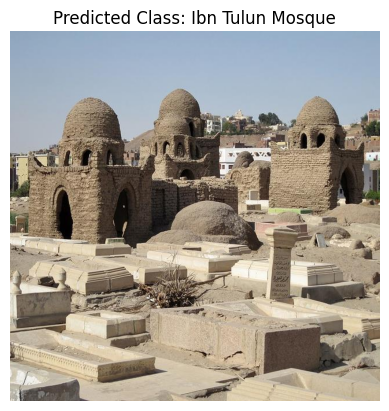

In [29]:
img_path = r"E:\data_final\valid\Fatimid_Cemetery_in_Aswan\0002_Assuan_Fatimidischer_Friedhof_03.jpg"
prepared_img = prepare_image(img_path)
prediction = model.predict(prepared_img)
predicted_class = np.argmax(prediction, axis=1)

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class[0]]

print(f"The image belongs to class: {predicted_label}")

img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_label}")
plt.axis('off')
plt.show()


In [22]:
#model.save(r'E:\New folder/final_classifier_model')

INFO:tensorflow:Assets written to: E:\New folder/final_classifier_model\assets


INFO:tensorflow:Assets written to: E:\New folder/final_classifier_model\assets


Model saved successfully in SavedModel format!


In [25]:
#class_indices = train_generator.class_indices
#classes = [class_name for class_name, index in sorted(class_indices.items(), key=lambda item: item[1])]
#with open(r'E:\New folder/final_classes.json', 'w') as file:
#    json.dump(classes, file)
#print("Classes saved successfully to classes.json")
#with open(r'E:\New folder/final_classes.txt', 'w') as file:
#    for class_name in classes:
#        file.write(class_name + '\n')
#print("Classes saved successfully to classes.txt")

Classes saved successfully to classes.json
Classes saved successfully to classes.txt


### 